In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict

# Reading the dataset
game_df_original = pd.read_json('../dataset/games.jl', lines=True, encoding='utf-8')
review_df = pd.read_json('../dataset/reviews.jl', lines=True, encoding='utf-8')

# Create a dataframe of tags for content based filtering
game_df = game_df_original[['tags','id']].dropna(subset=['tags', 'id'])
game_df = game_df.assign(genres=game_df['tags'].str.split(', ')).explode('tags')
game_df = game_df[['tags','id']]
one_hot_df = pd.get_dummies(game_df['tags'], prefix='tags')
result_df = pd.concat([game_df['id'], one_hot_df], axis=1)
df_tags = result_df.groupby('id').sum()
df_tags.index = df_tags.index.astype(int)
df_tags.fillna(0, inplace=True)

# Cleaning reviews dataframe
review_df = review_df[['product_id', 'recommended', 'user_id']]
review_df = review_df.drop_duplicates(subset=['product_id', 'user_id'])
review_df = review_df.dropna()

# Checking if the product id(game id) in the review data is matching the id(game id) in the games data as it might be an issue in some cases
game_index = game_df.id.values
common_games = (review_df['product_id'].isin(game_index))
review_df = review_df.loc[common_games]

# Seleting the reviews of users who have given minimum 15 reviews
user_review_count = review_df.groupby('user_id')['product_id'].count()
user_review_index = user_review_count[user_review_count > 15].index
review_df_min15 = review_df[(review_df["user_id"].isin(user_review_index))]

# Resampling the data
review_df_min15 = review_df_min15.sample(
    review_df_min15.shape[0], random_state=50)

# Getting training data and testing data with a 80/20 split
review_df_min15_train = review_df_min15.head(
    int(len(review_df_min15)*(80/100)))
review_df_min15_test = review_df_min15[~review_df_min15.index.isin(
    review_df_min15_train.index)]

# Creaing this for finding hybrid ROC-AUC
review_df_min15[['user_id', 'product_id', 'recommended']].to_csv('cg_content_based.csv')

# Function to find recommendations for a given user_id
def recommendation(user_id):

    # Creating a user vector (user profile)
    random_user_vec = review_df_min15_train[review_df_min15_train.user_id == user_id][[
        'product_id', 'recommended']]
    random_user_vec.set_index('product_id', inplace=True)
    random_user_vec.fillna(0, inplace=True)
    recommended_game_count = len(random_user_vec[random_user_vec > 0])
    random_user_vec = random_user_vec.squeeze()
    game_tag_pivot = df_tags.mul(random_user_vec, axis=0)
    game_tag_pivot.fillna(0, inplace=True)
    user_profile = game_tag_pivot.sum()/recommended_game_count

    # Finding already played and reviewed games
    played_games = random_user_vec.index

    # Finding similarity between user profile and games (via tags)
    cos_sim = cosine_similarity([user_profile], df_tags)
    cos_sim_df = pd.DataFrame(
        {'cosine_similarity': cos_sim[0], 'ind': df_tags.index})

    # Making sure already playes games are not recommended
    reco_games = cos_sim_df[~(cos_sim_df.ind.isin(played_games))].sort_values(
        by='cosine_similarity', ascending=False)[['ind', 'cosine_similarity']]

    reco_games.set_index('ind', inplace=True)
    final_game_suggestions = game_df_original[game_df_original.id.isin(
        reco_games.index)][['id']]
    final_game_suggestions = final_game_suggestions.merge(
        reco_games, left_on='id', right_on='ind')[['id', 'cosine_similarity']]
    final_game_suggestions = final_game_suggestions.values.tolist()
    return final_game_suggestions


# Function to calculate ROC
def ROC(list_of_users, threshold):

    user_predictions = defaultdict(list)

    for uid in list_of_users:
        pred = recommendation(uid)
        user_predictions[uid].append(pred)

    om_specificity = dict()
    sensitivity = dict()
    for uid, games in user_predictions.items():

        # Recommended liked games
        reco_l_games = [product_id for product_id,
                        weighted_avg in games[0] if weighted_avg > threshold]
        reco_l_games = set(reco_l_games)

        # Recommended unliked games
        reco_ul_games = [product_id for product_id,
                         weighted_avg in games[0] if weighted_avg < threshold]
        reco_ul_games = set(reco_ul_games)

        common_games_t = review_df_min15_test[review_df_min15_test.user_id == uid]
        ul_games = common_games_t[common_games_t.recommended ==
                                  0]['product_id'].values.tolist()
        ul_games = set(ul_games)
        l_games = common_games_t[common_games_t.recommended ==
                                 1]['product_id'].values.tolist()
        l_games = set(l_games)

        # Confusion matrix calculation
        true_positives = l_games & reco_l_games
        false_negatives = ul_games & reco_ul_games
        false_positives = ul_games & reco_l_games
        true_negatives = l_games & reco_ul_games

        om_specificity[uid] = len(false_positives) / (len(false_positives) + len(
            true_negatives)) if (len(false_positives) + len(true_negatives)) != 0 else 0
        sensitivity[uid] = len(true_positives) / (len(true_positives) + len(
            false_negatives)) if (len(true_positives) + len(false_negatives)) != 0 else 0

    return sensitivity, om_specificity


In [2]:
#Creating a list of threshold values for ROC_AUC calculation
number_list = []
s = 0
e = 1
number_gap = 0.1
for i in range(int((e-s)/number_gap)+1):
    number_list.append(s + i*number_gap)

#Cumulating list of users common between training and testing data    
list_of_users = list(set(review_df_min15_train.user_id) & set(review_df_min15_test.user_id))
list_of_users=[int(i) for i in list_of_users]

In [4]:
#Sensitivity and 1-Specificity calculation for ROC_AUC calcuation 
x =list()
y =list()
for i in number_list:
    sensitivity, om_specificity = ROC(list_of_users,i)
    print(sum(sens for sens in sensitivity.values()) / len(sensitivity))
    print(sum(oms for oms in om_specificity.values()) / len(om_specificity))
    y.append(sum(sens for sens in sensitivity.values()) / len(sensitivity))
    x.append(sum(oms for oms in om_specificity.values()) / len(om_specificity))

0.96
0.51
0.96
0.51
0.9508333333333333
0.49933333333333335
0.933958152958153
0.43574999999999997
0.8056956628570573
0.2652619047619048
0.6591507936507935
0.13374781427722604
0.37676262626262635
0.030438403701561593
0.12666666666666665
0.0045000000000000005
0.01
0.0016666666666666666
0.01
0.0014285714285714286
0.0
0.0


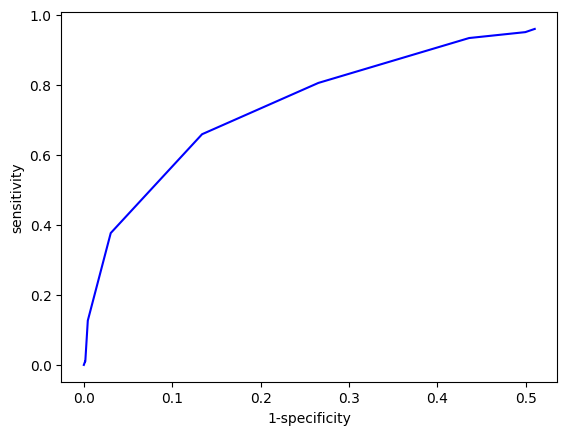

In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import auc
fig, ax = plt.subplots()

ax.plot(x, y, color='blue')
ax.set_xlabel('1-specificity')
ax.set_ylabel('sensitivity')

plt.savefig('ROC_Content_Based.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
roc_auc = auc(x, y)

# Print the AUC value
print(roc_auc)

In [7]:
#Saving data for final plot
content_based_df = pd.DataFrame({'x': x, 'y': y})
content_based_df.to_csv("ROC_content_based_data.csv")